# Forward Kinematics of the leg in the plane

If we constrain the first degree of freedom of the robot, we have a robot moving in the plane. So we can model it in 2D. The model is as follows
<img src="./2d_robot_model.png" width="300">

We have seen that the relative transforms between frames were
$$T_{SH} = \begin{bmatrix}\cos \theta_1 & -\sin \theta_1 & l_0\\
\sin\theta_1 & \cos\theta_1 & 0\\
0 & 0 & 1
 \end{bmatrix} \qquad T_{HK} = \begin{bmatrix}\cos \theta_2 & -\sin \theta_2 & 0\\
\sin\theta_2 & \cos\theta_2 & -l_1\\
0 & 0 & 1
 \end{bmatrix} \qquad T_{KF} = \begin{bmatrix}1 & 0 & 0\\
0 & 1 & -l_2\\
0 & 0 & 1
 \end{bmatrix}$$
 and the pose of the foot F (i.e. its position and orientation) with respect to frame {S} is
 $$\begin{bmatrix}\cos(\theta_1+\theta_2) & -\sin(\theta_1+\theta_2)& l_2\sin(\theta_1+\theta_2) + l_1\sin\theta_1 + l_0\\
\sin(\theta_1+\theta_2) & \cos(\theta_1+\theta_2) & -l_2\cos\theta_1+\theta_2)  - l_1\cos\theta1\\
0 & 0 & 1
 \end{bmatrix}$$

In [1]:
#setup nice plotting (use widget instead of notebook in the command below if you use jupyter lab)
%matplotlib notebook

# we import useful libraries
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

# we import the helper class / we will use a similar class to work with the real robot
from nyu_finger_simulator import NYUFingerSimulator

## Question 1: creating our building blocks
The goal of this question is to build functionality for rigid motion. Each rigid motion can be decomposed in translations and rotations, so they are our basic building blocks to construct any homogenous transforms.
1. Write a Translate() function that takes a 2D numpy vector as an argument and returns an homogeneous transform corresponding to a translation in the direction of the input. 
2. Write a Rotate() function that takes an angle as an argument and returns an homogeneous transform corresponding to a rotation of that angle.
3. How would you use these functions to compute $T_{SH}$, $T_{HK}$ and $T_{KF}$?
4. Compute $T_{SH}$ when $\theta_1 = \frac{\pi}{3}$ and verify your result by comparing it with the theoretical result.

You can use the code template below for the functions.

In [2]:
def translate(vector):
    transform = np.eye(3)    
    transform[0,2] = vector[0]
    transform[1,2] = vector[1]
    return transform

def rotate(angle):
    transform = np.eye(3)
    transform[0,0] = np.cos(angle)
    transform[0,1] = -np.sin(angle)
    transform[1,0] = np.sin(angle)
    transform[1,1] = np.cos(angle)
    return transform

l0 = 0.3
l1 = 0.16
l2 = 0.16
Tsh = translate([l0, 0]) @ rotate(np.pi/3)
print (Tsh)

[[ 0.5       -0.8660254  0.3      ]
 [ 0.8660254  0.5        0.       ]
 [ 0.         0.         1.       ]]


## Question 2: forward kinematics
Now we can use these series of transformation to compute the full forward kinematics for the foot, i.e. $T_{SF}$.
1. Write a function forward_kinematics() that takes 2 angles as input (the 2 DOFs of the planar robot) and returns T_SF. You may use the function template below.
2. Verify that the function is working correctly by computing the position/orientation of the foot when 1) $\theta_1=\theta_2 = 0$ and when 2) $\theta_1 = \pi$ and $\theta_2 = -\frac{\pi}{2}$. Compare with the theoretical result.

In [3]:
def forward_kinematics(theta1, theta2):
    l0 = 0.3
    l1 = 0.16
    l2 = 0.16
    
    Tsh = translate([l0, 0]) @ rotate(theta1)
    Thk = translate([0, -l1]) @ rotate(theta2)
    Tkf = translate([0, -l2])
    transform = Tsh @ Thk @ Tkf

    return transform

In [4]:
print (forward_kinematics(0, 0))
print (forward_kinematics(np.pi, -np.pi/2))

[[ 1.    0.    0.3 ]
 [ 0.    1.   -0.32]
 [ 0.    0.    1.  ]]
[[ 6.123234e-17 -1.000000e+00  4.600000e-01]
 [ 1.000000e+00  6.123234e-17  1.600000e-01]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]


## Question 3: tracking the motion of the foot
We are now ready to use the function with our simulator to figure out where the foot is. The following code runs a simulation of the robot that create a particular movement. There are two types of movements that can be selected by changing the variable "type_of_trajectory" to 0, 1 and 2.

For each type of trajectory (0, 1 and 2):
1. Use your forward_kinematics function in the following code to compute the position of the foot in frame {S} during the movement of the robot. Plot the motion of the foot in 2D using the function plot_foot_trajectory() below
2. What is the maximum and minimum height reached by the foot during the movement? And the maximum/minimum width?

3. Which motion type reaches the highest point? and the lowest?
4. Using the results of motion type 1, can you infer (approximately) joint angles of the robot that allows the foot to reach the position (0.29, -0.24)? How can you do this?

In [5]:
def generate_trajectory(t, type_of_trajectory):
    q_des = np.array([0.,0.,0.])
    dq_des = np.array([0.,0.,0.])
    
    if type_of_trajectory==0:
        q_des[1] = 0.6*np.cos(np.pi*t) + 0.7
        dq_des[1] = -0.6*np.pi*np.sin(np.pi*t)
        q_des[2] = -0.9*np.sin(np.pi*t+np.pi/4) - 1.4
        dq_des[2] = -0.9*np.pi*np.cos(np.pi*t+np.pi/4)
    elif type_of_trajectory==1:
        q_des[1] = 0.4*np.cos(np.pi*t) + 0.7
        dq_des[1] = -0.4*np.pi*np.sin(np.pi*t)
        q_des[2] = -0.8*np.cos(np.pi*t) - 1.4
        dq_des[2] = 0.8*np.pi*np.sin(np.pi*t)
    elif type_of_trajectory==2:
        q_des[1] = 0.6*np.cos(np.pi*t) + 0.7
        dq_des[1] = -0.6*np.pi*np.sin(np.pi*t)
        q_des[2] = -0.6*np.sin(np.pi*t-np.pi/4) - 1.4
        dq_des[2] = -0.6*np.pi*np.cos(np.pi*t-np.pi/4)
    return q_des, dq_des

In [6]:
def simulate_motion(type_of_trajectory):
    # we reset the simulation to the initial position we want to move
    robot.reset_state(generate_trajectory(0.,type_of_trajectory)[0])

    # we store information
    measured_positions = np.zeros([num_steps,3])
    measured_velocities = np.zeros_like(measured_positions)
    desired_torques = np.zeros_like(measured_positions)
    desired_positions = np.zeros_like(measured_positions)
    desired_velocities = np.zeros_like(measured_positions)
    time = np.zeros([num_steps])

    x_pos = np.zeros([num_steps,1])
    y_pos = np.zeros([num_steps,1])

    for i in range(num_steps):
        # get the current time
        time[i] = robot.dt * i

        # we get the position and velocities of the joints
        q, dq = robot.get_state()
        measured_positions[i,:] = q
        measured_velocities[i,:] = dq

        x_pos[i, :] = forward_kinematics(q[1], q[2])[0, 2]
        y_pos[i, :] = forward_kinematics(q[1], q[2])[1, 2]

        # we get the current desired positions and velocities
        q_des, dq_des = generate_trajectory(time[i], type_of_trajectory)

        desired_positions[i,:] = q_des
        desired_velocities[i,:] = dq_des

        error = q_des - q # the position error for all the joints (it's a 3D vector)
        d_error = dq_des-dq # the velocity error for all the joints

        # we compute the desired torques as a PD controller
        joint_torques = P * error + D * d_error
        desired_torques[i,:] = joint_torques

        # we send them to the robot and do one simulation step
        robot.send_joint_torque(joint_torques)
        robot.step()
    return x_pos, y_pos

In [7]:
def plot_foot_trajectory(x_pos, y_pos):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(x_pos,y_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot y position [m]')
    plt.xlim([-0.05,0.6])
    plt.ylim([-0.36, 0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')

In [8]:
robot = NYUFingerSimulator()

# we simulate for 5 seconds
run_time = 5.
num_steps = int(run_time/robot.dt)

# the PD gains
P = np.array([3., 3., 3.])
D = np.array([0.2, 0.2, 0.2])

the max. height is -0.13212502535147908
the min. height is -0.3102052579531968
the max. width is 0.3994983410402048
the min. width is 0.19445620183281692


<IPython.core.display.Javascript object>


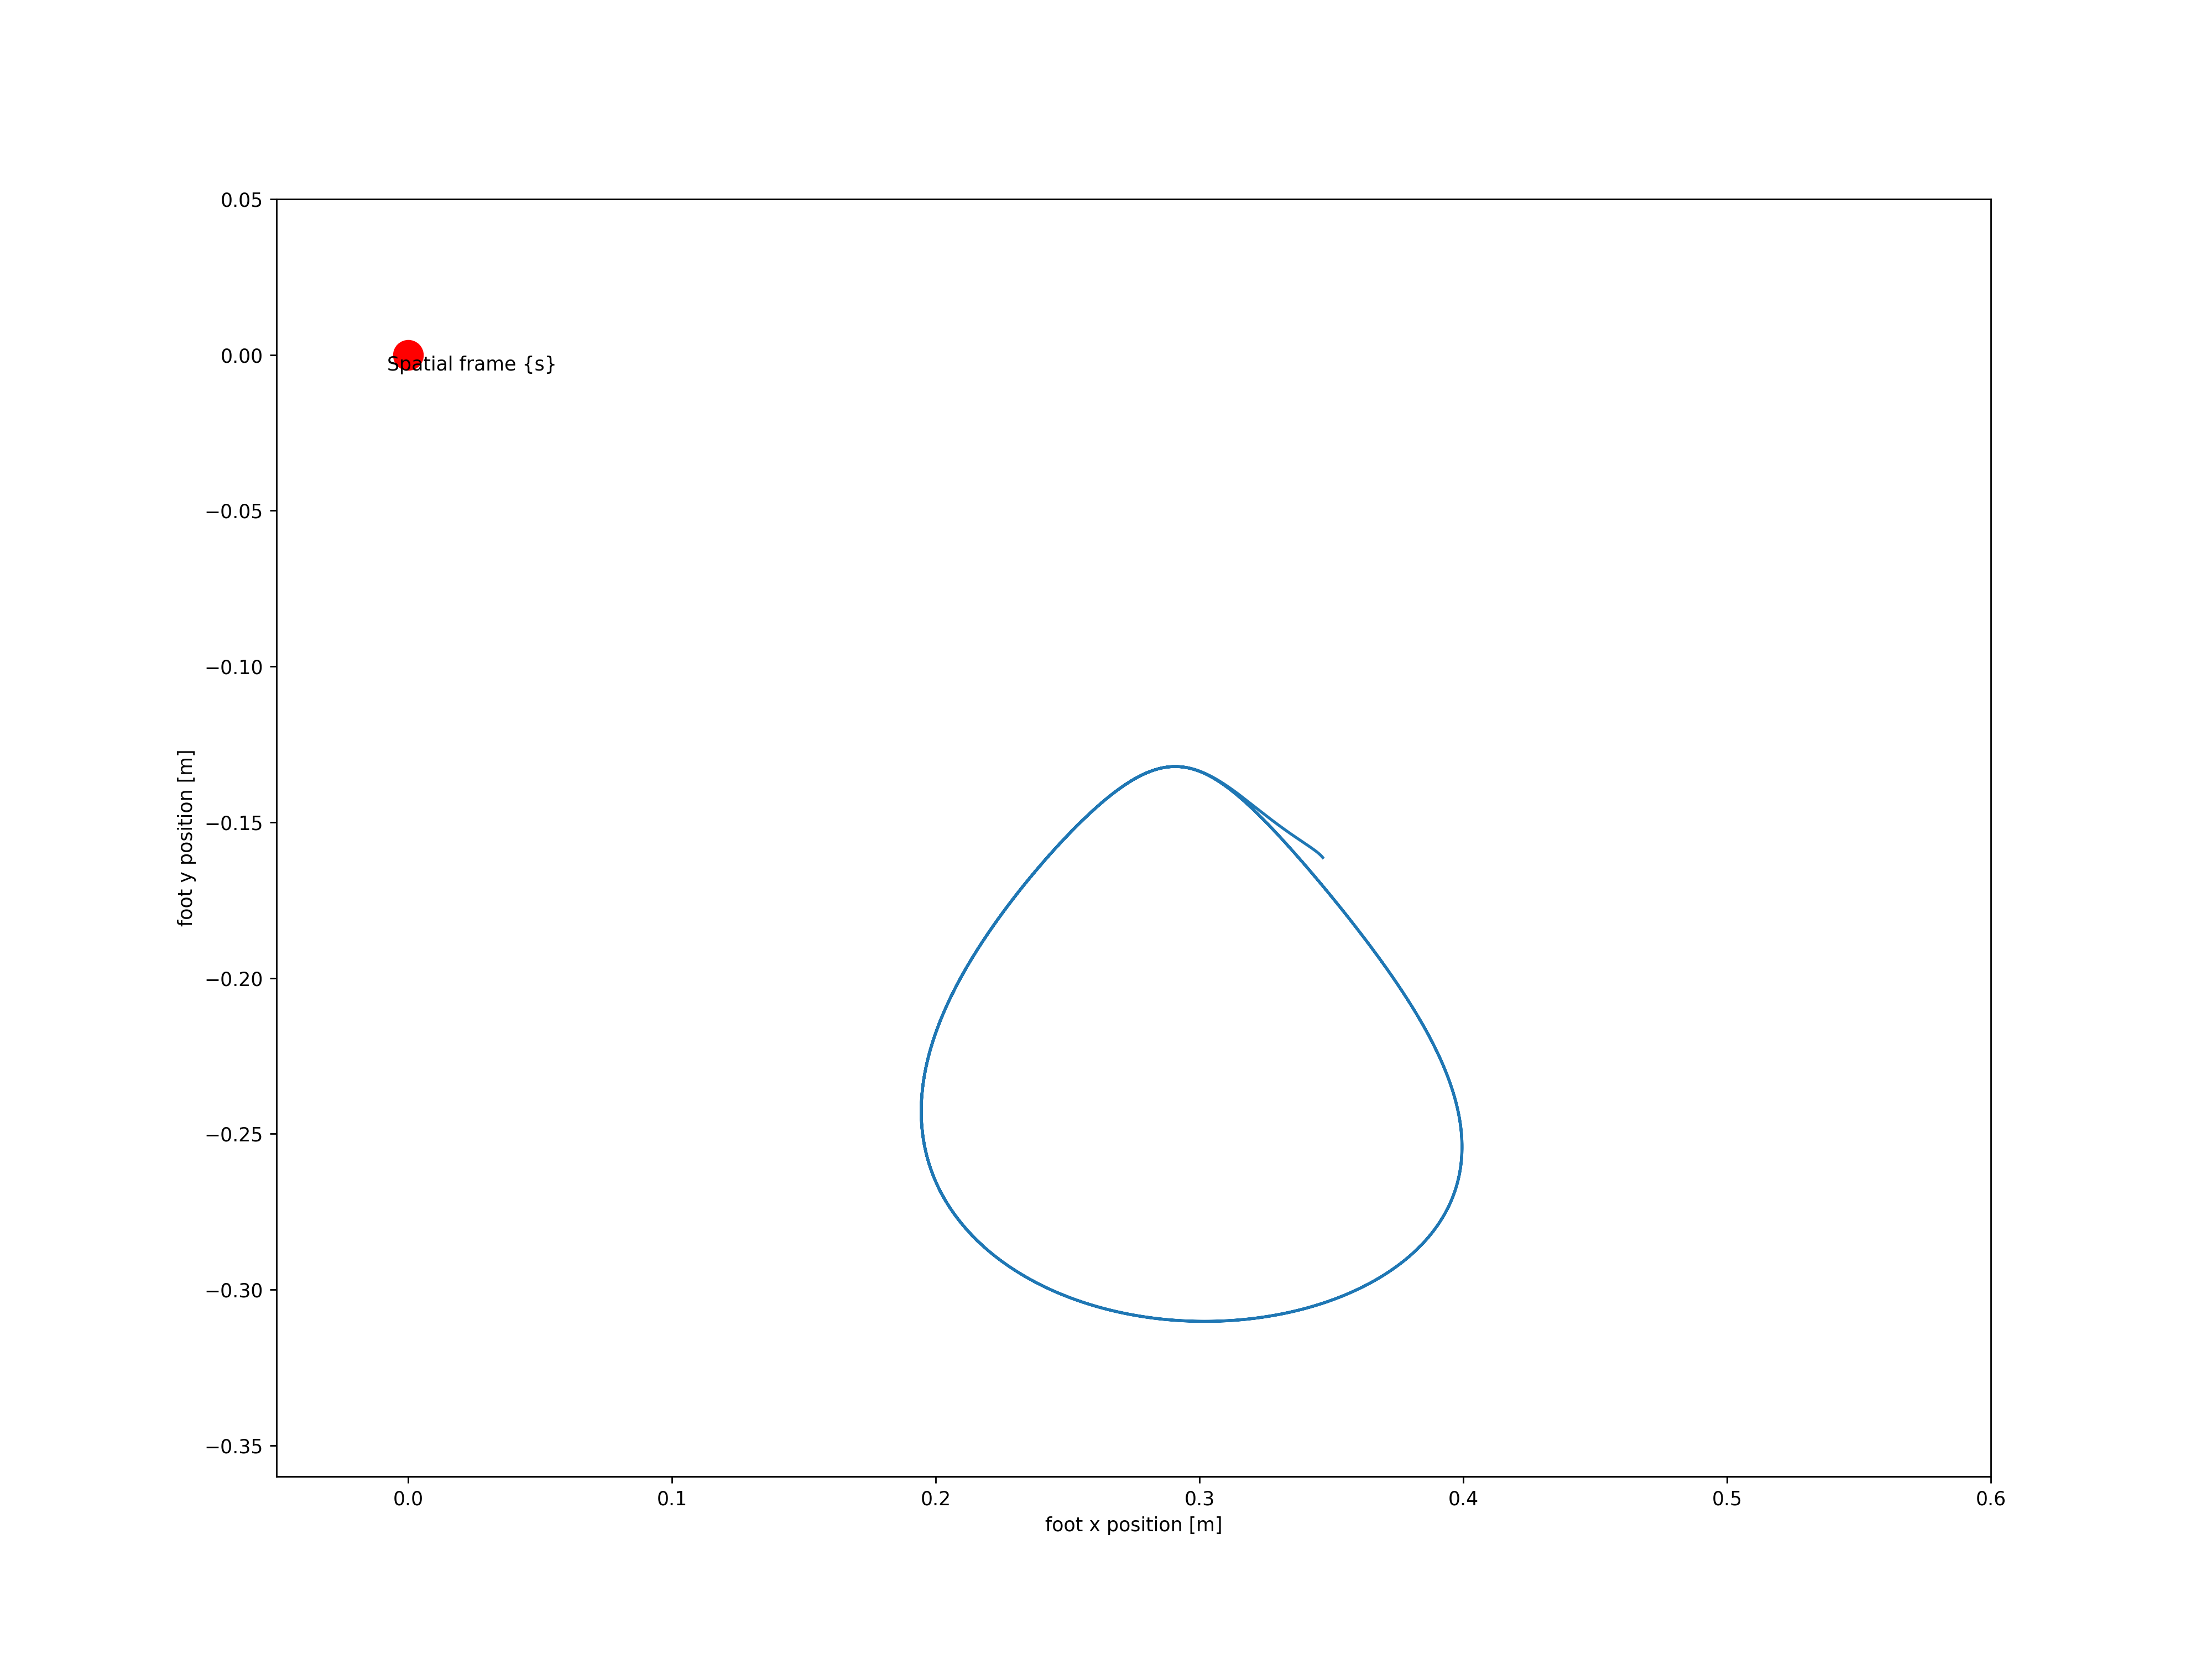

In [9]:
x_pos, y_pos = simulate_motion(0)
print ('the max. height is', np.max(y_pos))
print ('the min. height is', np.min(y_pos))
print ('the max. width is', np.max(x_pos))
print ('the min. width is', np.min(x_pos))
plot_foot_trajectory(x_pos, y_pos)

the max. height is -0.14515075885618475
the min. height is -0.30589144144565217
the max. width is 0.29999999999999993
the min. width is 0.29390019926327615


<IPython.core.display.Javascript object>


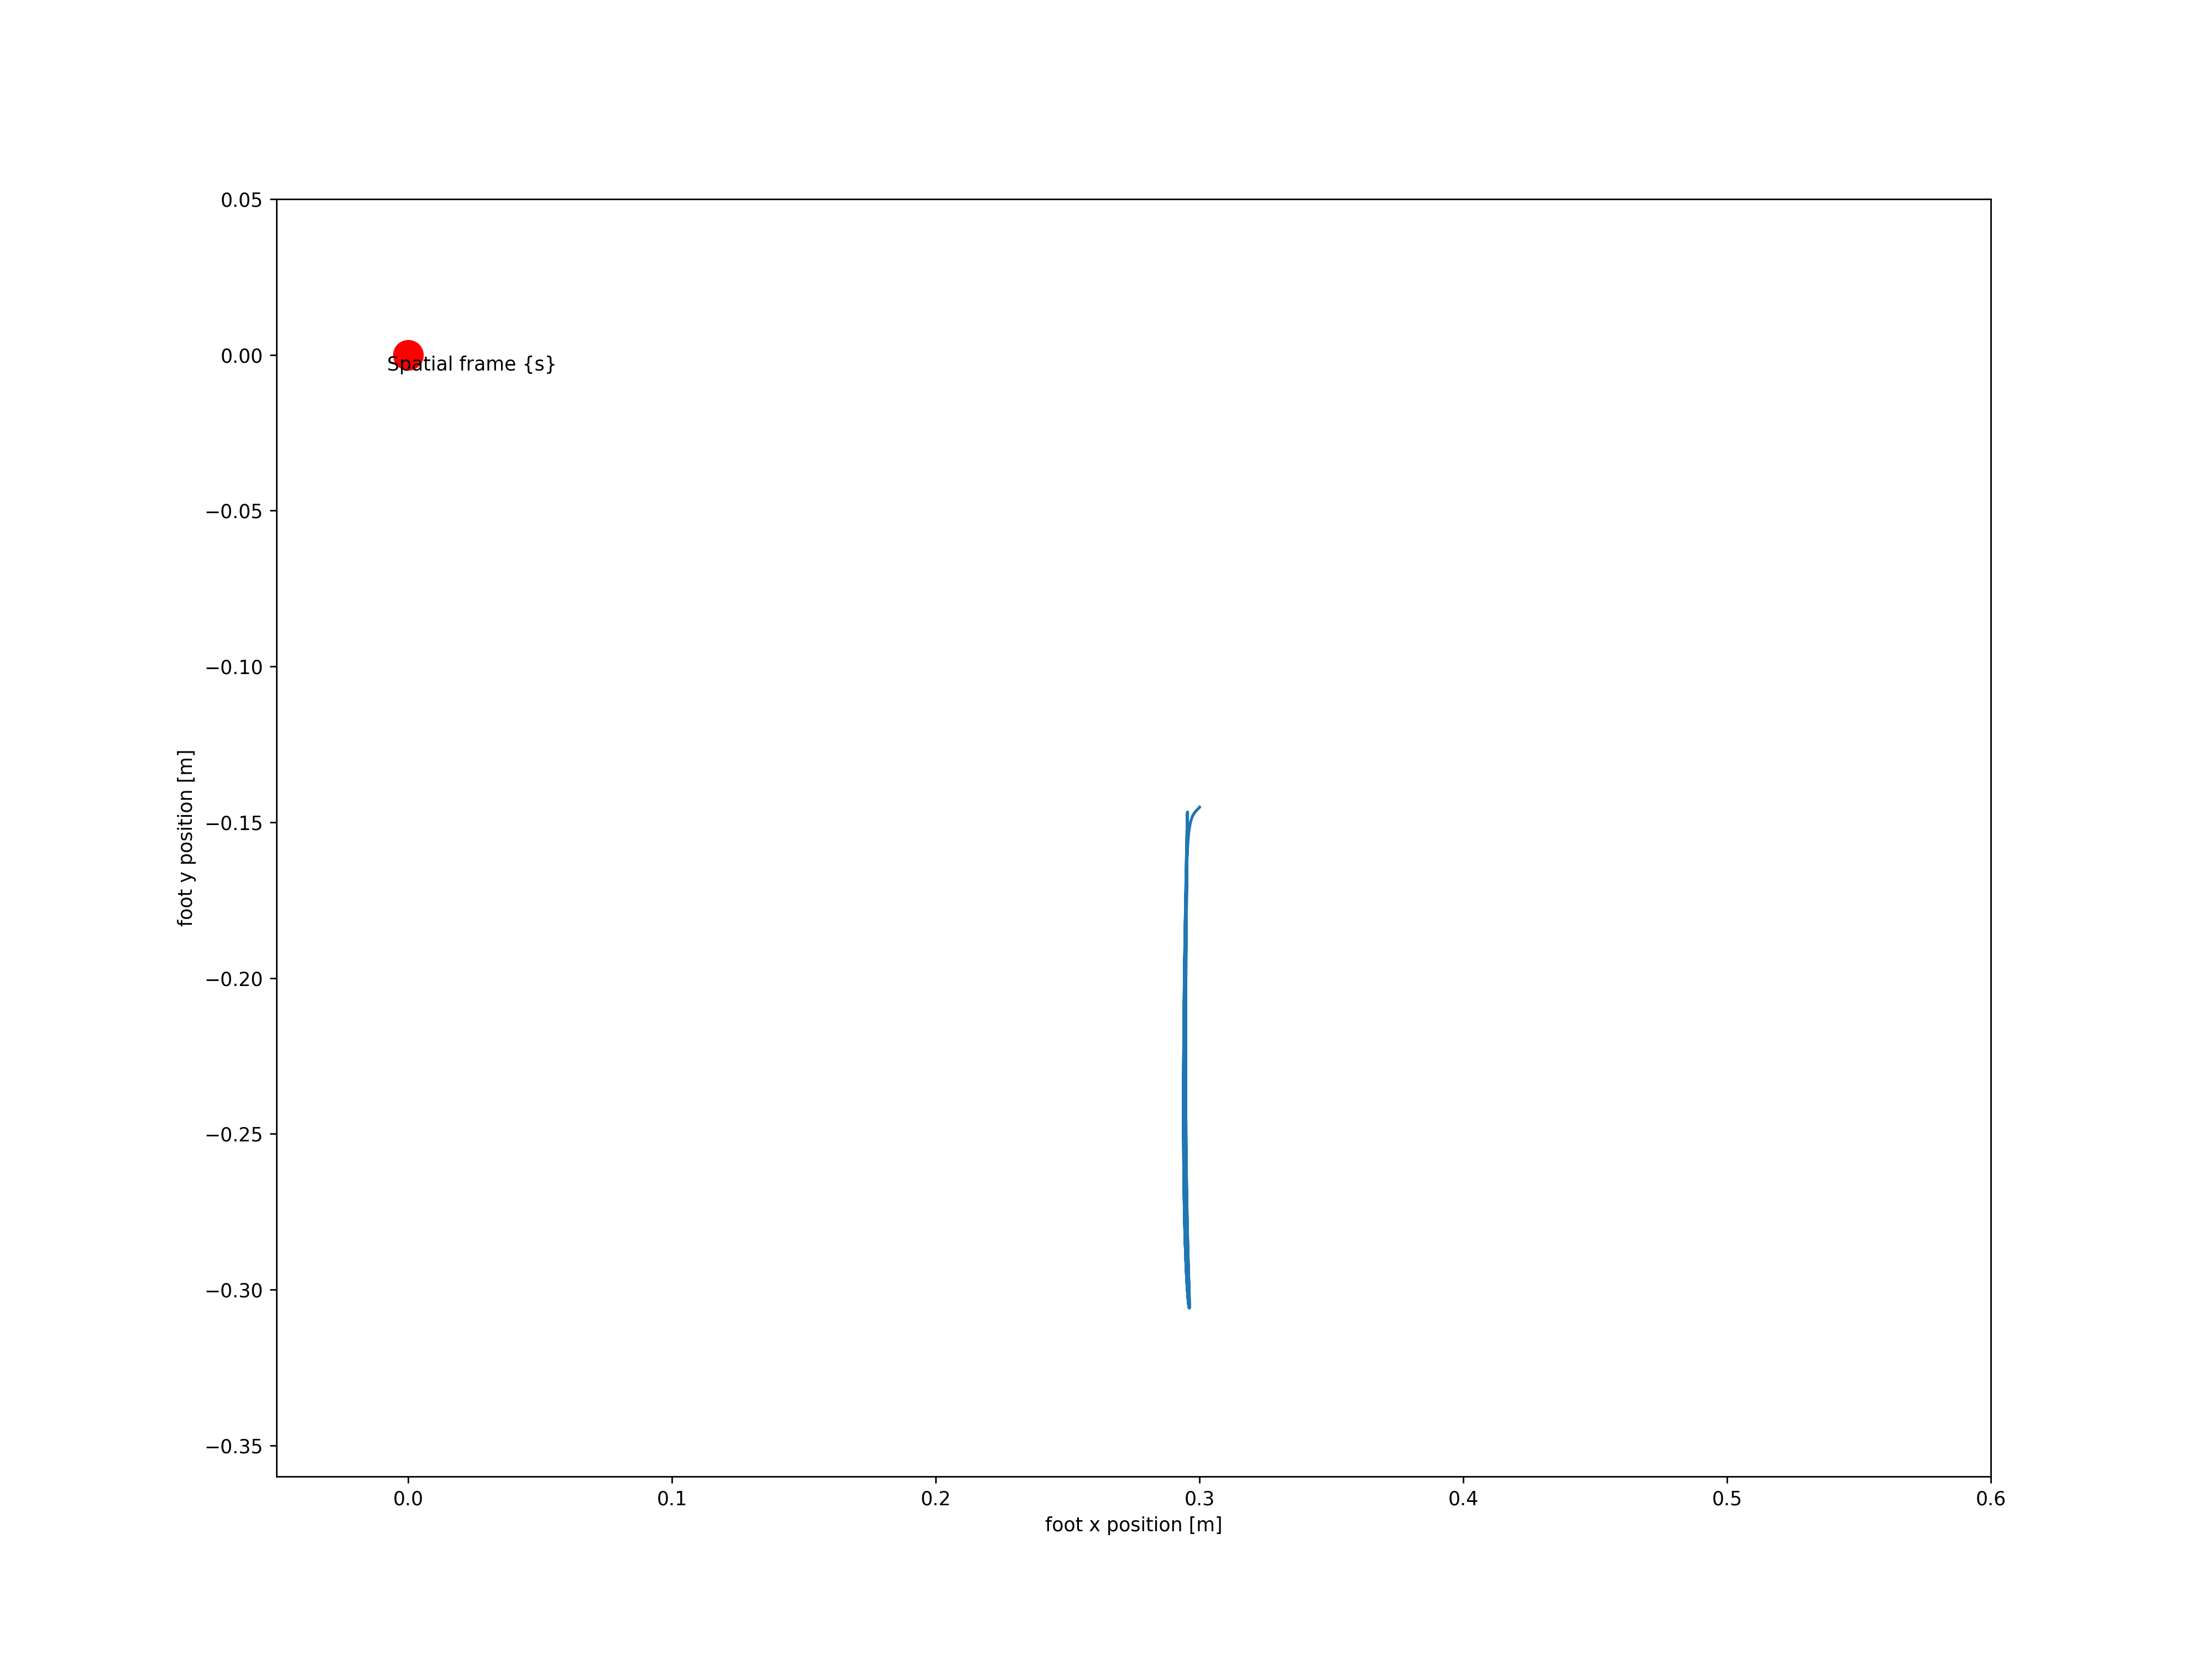

In [10]:
x_pos, y_pos = simulate_motion(1)
print ('the max. height is', np.max(y_pos))
print ('the min. height is', np.min(y_pos))
print ('the max. width is', np.max(x_pos))
print ('the min. width is', np.min(x_pos))
plot_foot_trajectory(x_pos, y_pos)


In [11]:
# compute the distance between the foot and the point of interest
xy_pos = np.vstack((x_pos, y_pos))
pos_of_interest = np.array([0.29, -0.24])
distance = np.zeros((num_steps, 1))
for i in range(num_steps):
    distance[i] = np.linalg.norm(xy_pos[i] - pos_of_interest)

# find the time where the foot is the closest to the point
closest_t = robot.dt * np.argmin(distance)

# find the corresponding joint angles at that time
print('the corresponding joint angles are', generate_trajectory(closest_t, 1)[0][1:3])

the corresponding joint angles are [ 0.72009773 -1.44019545]


the max. height is -0.12204732058984102
the min. height is -0.27846161004421544
the max. width is 0.5055408822647344
the min. width is 0.1573534350820052


<IPython.core.display.Javascript object>


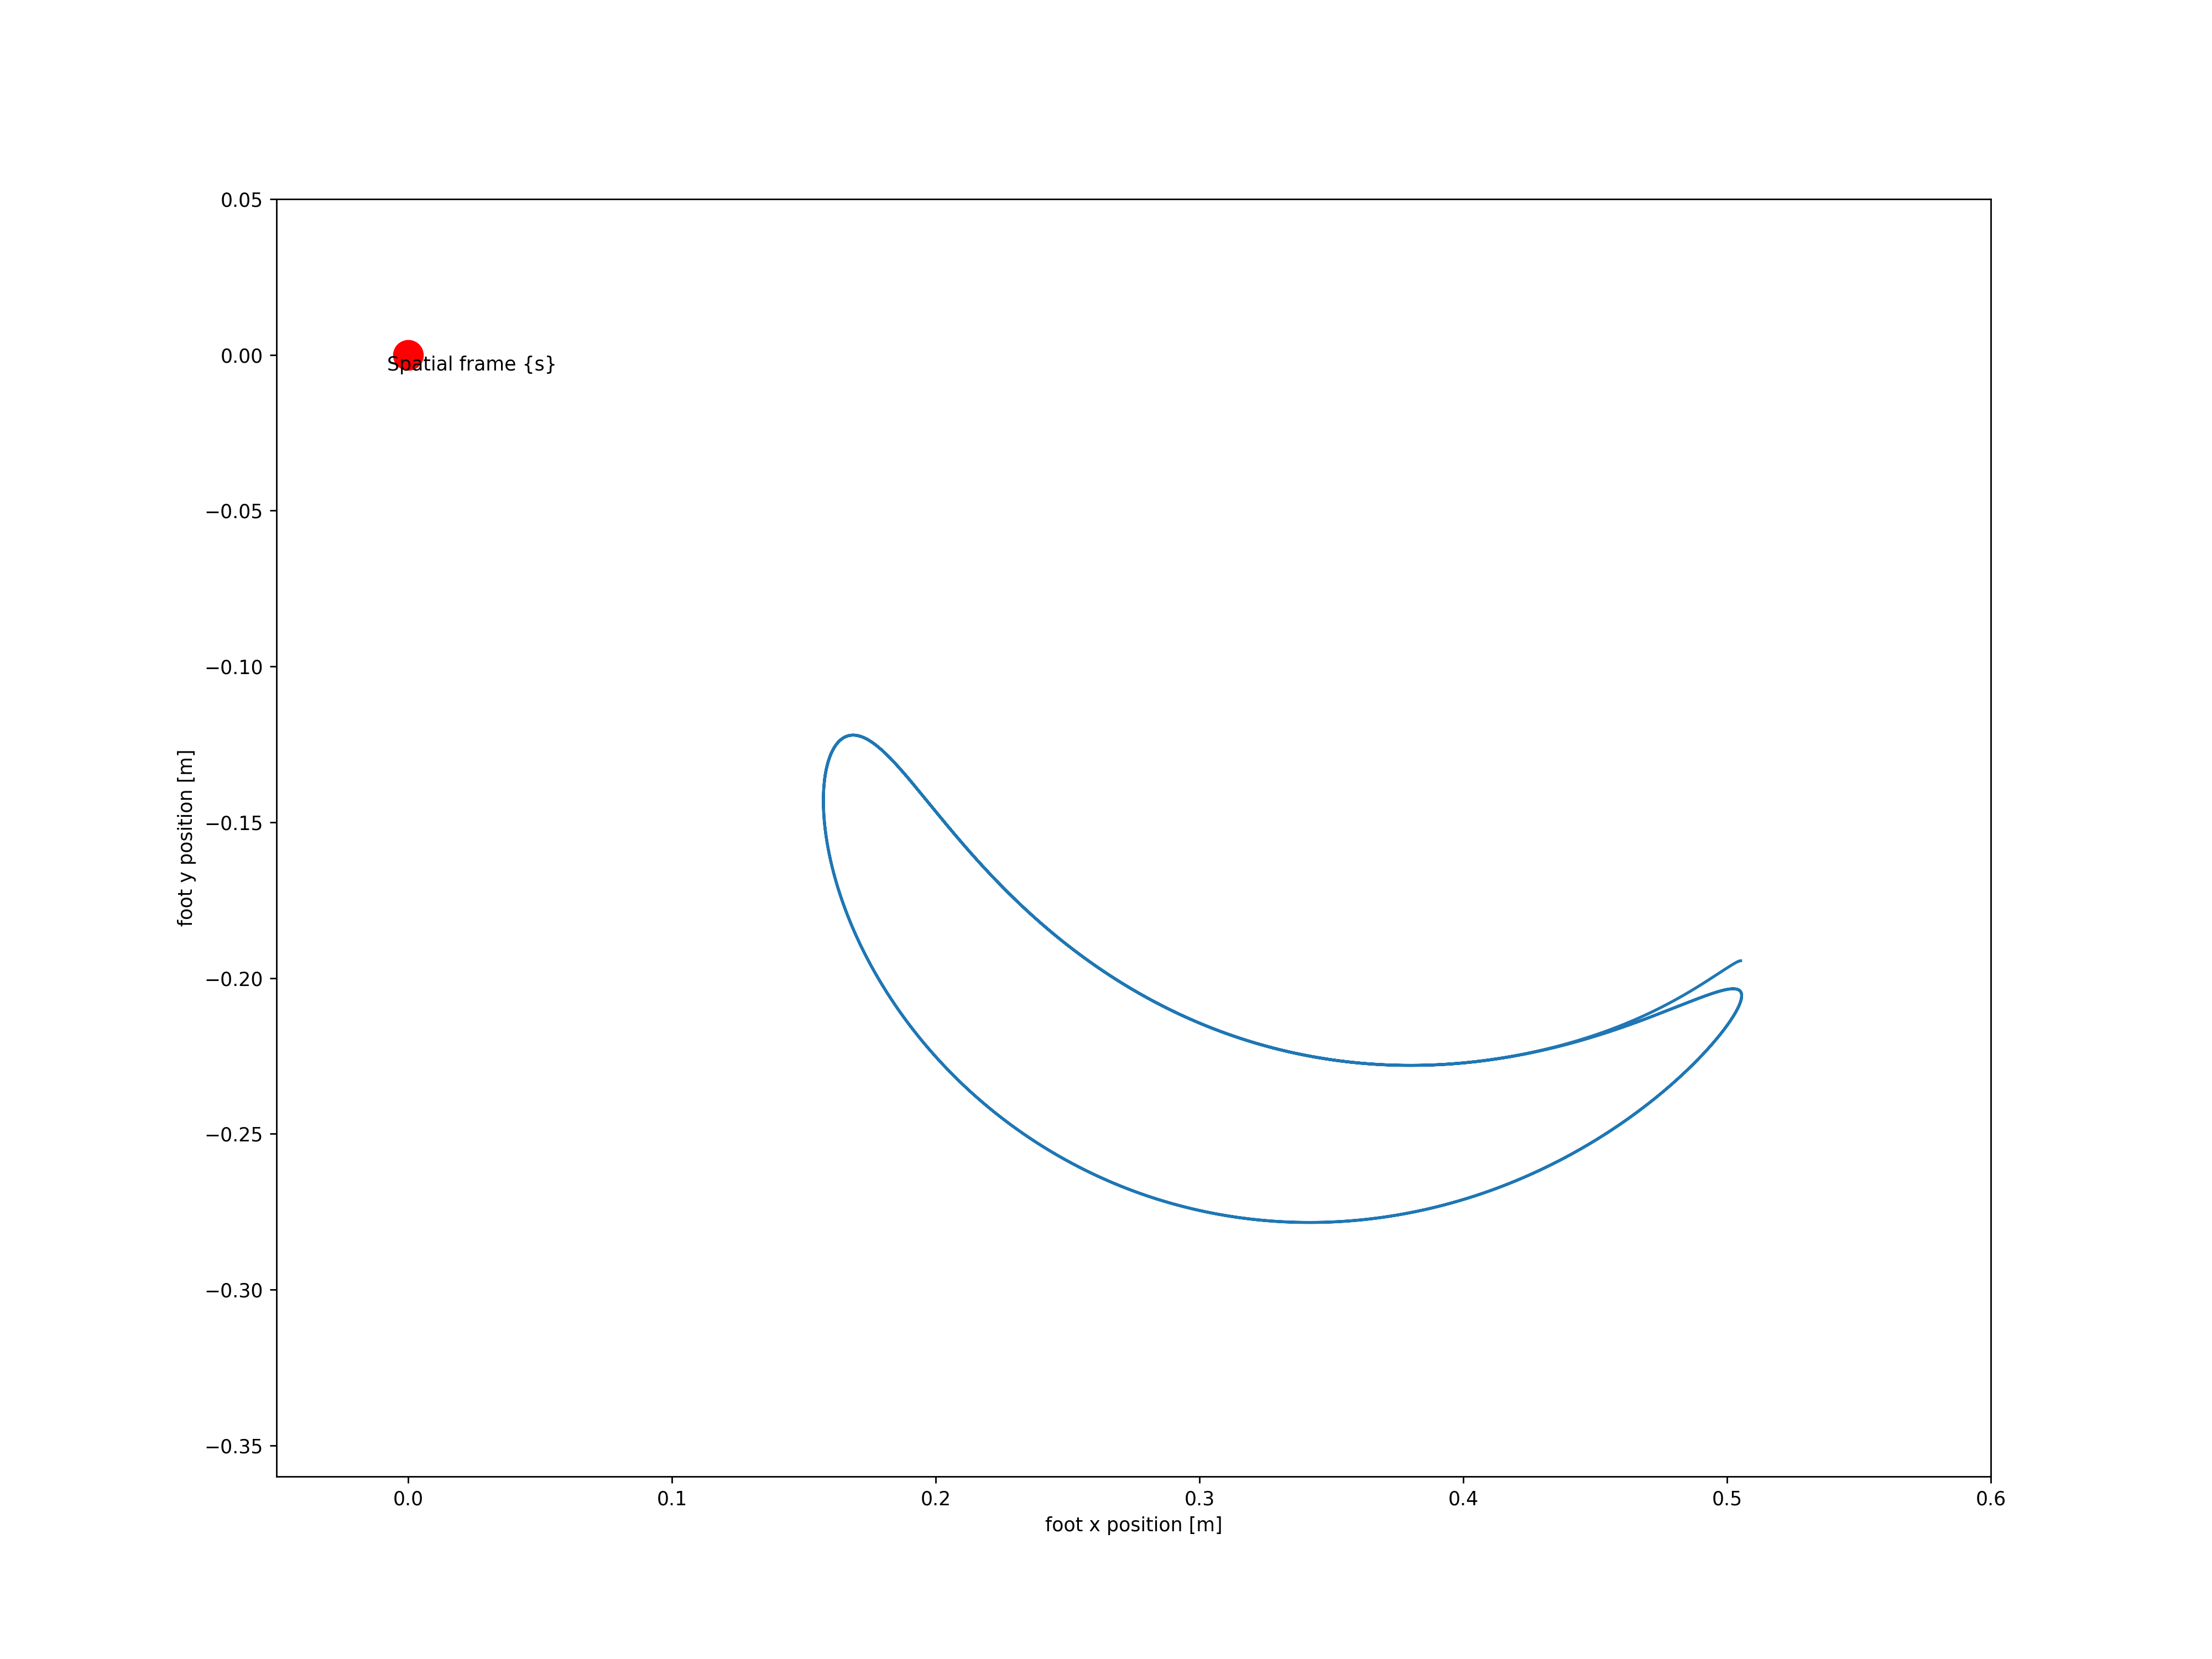

In [12]:
x_pos, y_pos = simulate_motion(2)
print ('the max. height is', np.max(y_pos))
print ('the min. height is', np.min(y_pos))
print ('the max. width is', np.max(x_pos))
print ('the min. width is', np.min(x_pos))
plot_foot_trajectory(x_pos, y_pos)